In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split

from __future__ import division

from sklearn import metrics
from sklearn.metrics import confusion_matrix

%matplotlib inline

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

import pydot


from scipy.stats import mode
from sklearn.ensemble.forest import _partition_estimators, _parallel_helper
from sklearn.tree._tree import DTYPE
from sklearn.externals.joblib import Parallel, delayed
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted

# Functions

In [2]:
RanDomState=1000
def bool_attack(count):
    if count>0:
        return 1
    else:
        return 0

# Algorithme de machine learning

# Area compute by hand

In [3]:
dfAreaHand = pd.read_csv('../data/aden_golfe_matrix_area_hand.csv',sep=';')
dfAreaHand[dfAreaHand["Count"]>0].head()

,Area,Count,Fortnight,Month,Type,Years,Activity
730,AL,1,1,2,Vehicle Carrier,2008,2
814,AP,1,1,2,Other,2008,2
906,K,1,1,2,Tanker,2008,2
986,K,1,1,2,Tug,2008,2
1506,K,1,2,3,Vehicle Carrier,2008,2


## Pre-traitement

### Attack column

On créé une colonne pour savoir si il y a une attaque ou non.

In [4]:
dfAreaHand['Attack'] = dfAreaHand.apply(lambda row: bool_attack(row['Count']), axis=1)

### Binary

Le but de ce paragraphe est de transformer la colonne "Area" en colonnes binaire, c'est à dire de créer autant de colonnes que d'observations possibles

In [8]:
def binaryColumn(df,uniqueArea,uniqueType):
    
    featureBinary=[]

    for i in range(0,len(uniqueArea)):
        nameColArea='Area_'+str(uniqueArea[i])
        df[nameColArea]=0
        featureBinary.append(nameColArea)

    for i in range(0,len(uniqueType)):
        nameColType='Type_'+str(uniqueType[i])
        df[nameColType]=0
        featureBinary.append(nameColType)

    for index, row in df.iterrows():
        df.set_value(index, "Area_"+str(row['Area']),1)
        df.set_value(index, "Type_"+str(row['Type']),1)
    
    return df,featureBinary


uniqueArea=dfAreaHand["Area"].unique()
uniqueType=dfAreaHand["Type"].unique()

dfAreaHand,featureBinary=binaryColumn(dfAreaHand,uniqueArea,uniqueType)

print dfAreaHand["Type"].unique()

dfAreaHand["Area_new"] = dfAreaHand["Area"].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, 'AA': 27, 'AB': 28, 'AC': 29, 'AD': 30, 'AE': 31, 'AF': 32, 'AG': 33, 'AH': 34, 'AI': 35, 'AJ': 36, 'AK': 37, 'AL': 38, 'AM': 39, 'AN': 40, 'AO': 41, 'AP': 42, 'AQ': 43, 'AR': 44, 'AR': 45}).astype(int)
dfAreaHand["Type_new"] = dfAreaHand["Type"].map({'Vehicle Carrier': 1, 'Tanker': 2, 'Offshore Exploitation': 3, 'Other': 4, 'Tug': 5,'Vessel': 6, 'Barge': 7, 'Military': 8,'Ship':9}).astype(int)

dfAreaHand.head()

['Vehicle Carrier' 'Other' 'Tanker' 'Tug' 'Vessel' 'Barge'
 'Offshore Exploitation' 'Military' 'Ship']


,Area,Count,Fortnight,Month,Type,Years,Activity,Attack,Area_A,Area_AA,...,Type_Other,Type_Tanker,Type_Tug,Type_Vessel,Type_Barge,Type_Offshore Exploitation,Type_Military,Type_Ship,Area_new,Type_new
0,A,0,1,1,Vehicle Carrier,2008,2,0,1,0,...,0,0,0,0,0,0,0,0,1,1
1,AA,0,1,1,Vehicle Carrier,2008,2,0,0,1,...,0,0,0,0,0,0,0,0,27,1
2,AB,0,1,1,Vehicle Carrier,2008,2,0,0,0,...,0,0,0,0,0,0,0,0,28,1
3,AC,0,1,1,Vehicle Carrier,2008,2,0,0,0,...,0,0,0,0,0,0,0,0,29,1
4,AE,0,1,1,Vehicle Carrier,2008,2,0,0,0,...,0,0,0,0,0,0,0,0,31,1


On définit les colonnes qui vont servir à contruire notre modèle.

In [9]:
features=['Activity','Fortnight','Month','Years']
features=np.concatenate([features,featureBinary]).tolist()

print features
target='Attack'

['Activity', 'Fortnight', 'Month', 'Years', 'Area_A', 'Area_AA', 'Area_AB', 'Area_AC', 'Area_AE', 'Area_AF', 'Area_AG', 'Area_AH', 'Area_AI', 'Area_AJ', 'Area_AL', 'Area_AM', 'Area_AN', 'Area_AO', 'Area_AP', 'Area_AQ', 'Area_AR', 'Area_B', 'Area_C', 'Area_D', 'Area_E', 'Area_F', 'Area_G', 'Area_H', 'Area_I', 'Area_J', 'Area_K', 'Area_L', 'Area_M', 'Area_N', 'Area_O', 'Area_P', 'Area_R', 'Area_S', 'Area_T', 'Area_V', 'Area_W', 'Area_X', 'Area_Y', 'Area_Z', 'Type_Vehicle Carrier', 'Type_Other', 'Type_Tanker', 'Type_Tug', 'Type_Vessel', 'Type_Barge', 'Type_Offshore Exploitation', 'Type_Military', 'Type_Ship']


### Sampling 

On se rend compte qu'il n'y a qu'un pourcent des lignes qui contiennent des attaques. On redéfinit notre dataframe pour avoir autant de attaques que de non-attaque.

In [12]:
Sampling=True

if Sampling:
    df_attack_raw = dfAreaHand[dfAreaHand[target] == 1]
    df_non_attack_raw = dfAreaHand[dfAreaHand[target] == 0]
    percentage = len(df_attack_raw)/float(len(df_non_attack_raw))
    print "pourcentage de ligne comportant des attaques : "+str(percentage*100)
    df_non_attack=dfAreaHand.sample(frac=percentage, random_state=1000)
    print str(len(df_non_attack))+'/'+str(len(df_non_attack_raw))

    DfSampling=df_non_attack.append(df_attack_raw)
else:
    DfSampling=dfAreaHand

pourcentage de ligne comportant des attaques : 1.26243177176
764/59726


# Machine learning

## Cross validation Random Forest

Dans cette partie, nous paramétrons notre modèle, en l'occurence ici Random Forest.

### N estimators

Nous faisons varier le nombre d'arbres: entre 1 et 2000. Nous mettons tous les résulats dans un tableau.

In [29]:
tabScore=[]
tabScore2=[]
rangeTab=xrange(1, 2000, 200)
for alpha in rangeTab:
    score=0
    score2=0
    print "----------------------------------------------------------"
    print alpha

    dfTrain, dfTest = train_test_split(DfSampling, test_size=0.20, random_state=RanDomState)
    model = RandomForestClassifier(random_state=1,n_estimators=alpha,n_jobs=4)
    model=model.fit(dfTrain[features], dfTrain[target])
    predictions=model.predict(dfTest[features])
    #print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
    score2=model.score(dfTest[features], dfTest[target])

    currentScoreTab=[]
    for i in (2009,2010,2011,2012,2013,2014):
        #print "----------------------------------------------------------"
        #print i
        dfTrain=DfSampling[DfSampling['Years']==i-1]
        dfTest=DfSampling[(DfSampling['Years']==i)]
        model = RandomForestClassifier(random_state=1,n_estimators=alpha,n_jobs=4)
        model=model.fit(dfTrain[features], dfTrain[target])

        predictions=model.predict(dfTest[features])
        #print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
        currentScore=model.score(dfTest[features], dfTest[target])
        currentScoreTab.append(currentScore)
        
        #print "Pourcentage de précision : "+str(currentScore)
    score=sum(currentScoreTab) / float(len(currentScoreTab))
    print " score avec split by years : "+str(score)
    print " score avec split randomly : "+str(score2)
    
    
    tabScore.append(score)
    tabScore2.append(score2)
    
print tabScore
print tabScore2

----------------------------------------------------------
1
 score avec split by years : 0.709751007171
 score avec split randomly : 0.796052631579
----------------------------------------------------------
201
 score avec split by years : 0.801857751215
 score avec split randomly : 0.838815789474
----------------------------------------------------------
401
 score avec split by years : 0.802604322757
 score avec split randomly : 0.842105263158
----------------------------------------------------------
601
 score avec split by years : 0.803677648057
 score avec split randomly : 0.838815789474
----------------------------------------------------------
801
 score avec split by years : 0.801944283701
 score avec split randomly : 0.835526315789
----------------------------------------------------------
1001
 score avec split by years : 0.802539521797
 score avec split randomly : 0.845394736842
----------------------------------------------------------
1201
 score avec split by years : 0.

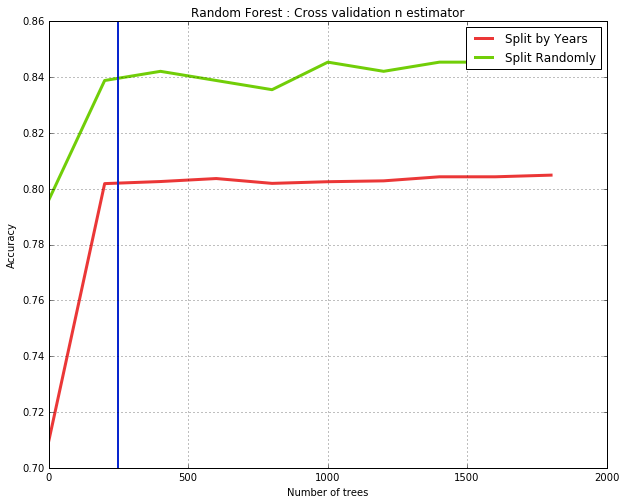

In [30]:
plt.figure(figsize=(10,8))
plt.plot(rangeTab,tabScore, '-', color='#EB3737', linewidth=3, label='Split by Years')
plt.plot(rangeTab,tabScore2, '-', color='#71ce08', linewidth=3, label='Split Randomly')
plt.axvline(x=250,linewidth=2, color='#0825ce')
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Random Forest : Cross validation n estimator")
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.show()

### max feature

In [31]:
tabScore=[]
tabScore2=[]
rangeTab=xrange(1, 15, 1)

for alpha in rangeTab:
    score=0
    score2=0
    print "----------------------------------------------------------"
    print alpha
    
    dfTrain, dfTest = train_test_split(DfSampling, test_size=0.20, random_state=RanDomState)
    model = RandomForestClassifier(random_state=1,max_features=alpha,n_jobs=4)
    model=model.fit(dfTrain[features], dfTrain[target])
    predictions=model.predict(dfTest[features])
    #print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
    score2=model.score(dfTest[features], dfTest[target])

    currentScoreTab=[]
    for i in (2009,2010,2011,2012,2013,2014):
        #print "----------------------------------------------------------"
        #print i
        dfTrain=DfSampling[DfSampling['Years']==i-1]
        dfTest=DfSampling[(DfSampling['Years']==i)]
        model = RandomForestClassifier(random_state=1,max_features=alpha,n_jobs=3)
        model=model.fit(dfTrain[features], dfTrain[target])

        predictions=model.predict(dfTest[features])
        #print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
        currentScore=model.score(dfTest[features], dfTest[target])
        currentScoreTab.append(currentScore)
        
        #print "Pourcentage de précision : "+str(currentScore)
    score=sum(currentScoreTab) / float(len(currentScoreTab))
    
    print " score avec split by years : "+str(score)
    print " score avec split randomly : "+str(score2)
    
    tabScore.append(score)
    tabScore2.append(score2)
    
print tabScore
print tabScore2

----------------------------------------------------------
1
 score avec split by years : 0.751648886156
 score avec split randomly : 0.8125
----------------------------------------------------------
2
 score avec split by years : 0.774115268224
 score avec split randomly : 0.825657894737
----------------------------------------------------------
3
 score avec split by years : 0.78621853413
 score avec split randomly : 0.8125
----------------------------------------------------------
4
 score avec split by years : 0.794982611187
 score avec split randomly : 0.842105263158
----------------------------------------------------------
5
 score avec split by years : 0.790795400096
 score avec split randomly : 0.842105263158
----------------------------------------------------------
6
 score avec split by years : 0.787032687589
 score avec split randomly : 0.842105263158
----------------------------------------------------------
7
 score avec split by years : 0.785062384682
 score avec split 

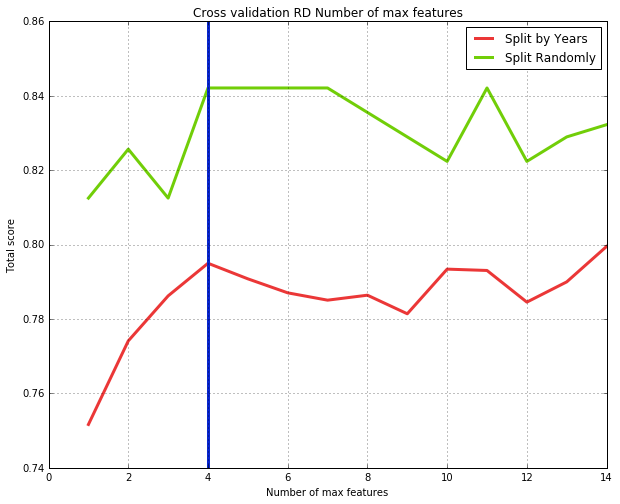

In [33]:
plt.figure(figsize=(10,8))
plt.plot(rangeTab,tabScore, '-', color='#EB3737', linewidth=3, label='Split by Years')
plt.plot(rangeTab,tabScore2, '-', color='#71ce08', linewidth=3, label='Split Randomly')
plt.axvline(x=4,linewidth=3, color='#0825ce')
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Cross validation RD Number of max features")
plt.xlabel('Number of max features')
plt.ylabel('Total score')
plt.show()

## Best Random forest

In [34]:
years_prediction=2014
dfTrain=DfSampling[DfSampling['Years']<years_prediction]
dfTest=DfSampling[(DfSampling['Years']==years_prediction)]

print " "
print "Entrainement : Nombre d'attaques /nombre de ligne : "+str(len(dfTrain[dfTrain['Count']!=0]))+'/'+str(len(dfTrain))
print "Test : Nombre d'attaques /nombre de ligne : "+str(len(dfTest[dfTest['Count']!=0]))+'/'+str(len(dfTest))

 
Entrainement : Nombre d'attaques /nombre de ligne : 742/1395
Test : Nombre d'attaques /nombre de ligne : 16/123


In [35]:
model = RandomForestClassifier(random_state=1,n_estimators=250,max_features=1)
model=model.fit(dfTrain[features], dfTrain[target])

predictions=model.predict(dfTest[features])
print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))

print "Pourcentage de précision : "+str(model.score(dfTest[features], dfTest[target]))
cm = confusion_matrix(dfTest[target], predictions)

Nombre d'attaques prévus/Nombre d'attaques réel: 11/16
Pourcentage de précision : 0.910569105691


In [36]:
pd.crosstab(dfTest[target],predictions, colnames=['preds']).apply(lambda r: r/r.sum(), axis=1)

preds,0,1
Attack,,
0,0.971963,0.028037
1,0.500000,0.500000


In [37]:
pd.crosstab(dfTest[target],predictions, colnames=['preds'])

preds,0,1
Attack,,
0,104,3
1,8,8


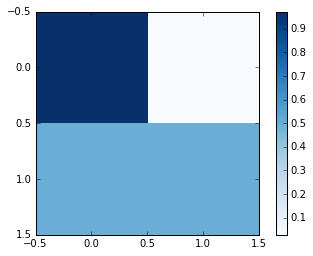

In [38]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

## Cross validation Gradient boosting

### N estimators

In [41]:
tabScore=[]
tabScore2=[]
rangeTab=xrange(1, 1500, 150)
for alpha in rangeTab:
    score=0
    score2=0
    print "----------------------------------------------------------"
    print alpha

    dfTrain, dfTest = train_test_split(DfSampling, test_size=0.20, random_state=RanDomState)
    model = GradientBoostingClassifier(random_state=1,n_estimators=alpha)
    model=model.fit(dfTrain[features], dfTrain[target])
    predictions=model.predict(dfTest[features])
    #print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
    score2=model.score(dfTest[features], dfTest[target])

    currentScoreTab=[]
    for i in (2009,2010,2011,2012,2013,2014):
        #print "----------------------------------------------------------"
        #print i
        dfTrain=DfSampling[DfSampling['Years']==i-1]
        dfTest=DfSampling[(DfSampling['Years']==i)]
        model = GradientBoostingClassifier(random_state=1,n_estimators=alpha)
        model=model.fit(dfTrain[features], dfTrain[target])

        predictions=model.predict(dfTest[features])
        #print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
        currentScore=model.score(dfTest[features], dfTest[target])
        currentScoreTab.append(currentScore)
        
        #print "Pourcentage de précision : "+str(currentScore)
    score=sum(currentScoreTab) / float(len(currentScoreTab))
    
    print " score avec split by years : "+str(score)
    print " score avec split randomly : "+str(score2)
    
    
    tabScore.append(score)
    tabScore2.append(score2)
    
print tabScore
print tabScore2

----------------------------------------------------------
1
 score avec split by years : 0.681567040472
 score avec split randomly : 0.789473684211
----------------------------------------------------------
151
 score avec split by years : 0.777779340465
 score avec split randomly : 0.845394736842
----------------------------------------------------------
301
 score avec split by years : 0.774126464132
 score avec split randomly : 0.855263157895
----------------------------------------------------------
451
 score avec split by years : 0.766593309423
 score avec split randomly : 0.842105263158
----------------------------------------------------------
601
 score avec split by years : 0.767253348478
 score avec split randomly : 0.848684210526
----------------------------------------------------------
751
 score avec split by years : 0.765358285487
 score avec split randomly : 0.848684210526
----------------------------------------------------------
901
 score avec split by years : 0.76

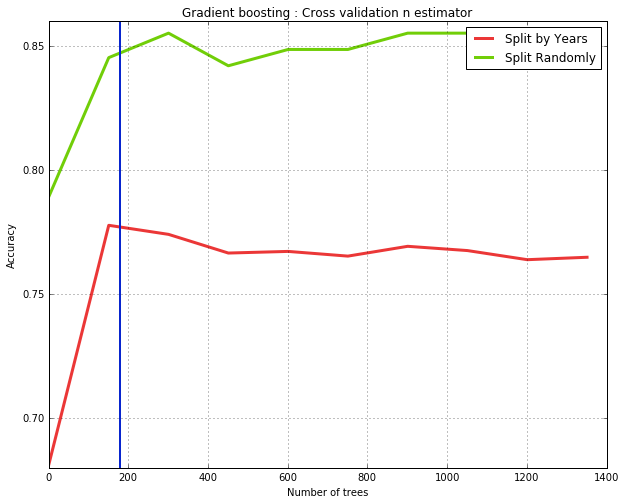

In [43]:
plt.figure(figsize=(10,8))
plt.plot(rangeTab,tabScore, '-', color='#EB3737', linewidth=3, label='Split by Years')
plt.plot(rangeTab,tabScore2, '-', color='#71ce08', linewidth=3, label='Split Randomly')
plt.axvline(x=180,linewidth=2, color='#0825ce')
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Gradient boosting : Cross validation n estimator")
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.show()

### Max features 

In [45]:
tabScore=[]
tabScore2=[]
rangeTab=xrange(1, 12, 1)

for alpha in rangeTab:
    score=0
    score2=0
    print "----------------------------------------------------------"
    print alpha
    
    dfTrain, dfTest = train_test_split(DfSampling, test_size=0.20, random_state=RanDomState)
    model = GradientBoostingClassifier(random_state=1,max_features=alpha)
    model=model.fit(dfTrain[features], dfTrain[target])
    predictions=model.predict(dfTest[features])
    #print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
    score2=model.score(dfTest[features], dfTest[target])

    currentScoreTab=[]
    for i in (2009,2010,2011,2012,2013,2014):
        #print "----------------------------------------------------------"
        #print i
        dfTrain=DfSampling[DfSampling['Years']<i]
        dfTest=DfSampling[(DfSampling['Years']==i)]
        model = GradientBoostingClassifier(random_state=1,max_features=alpha)
        model=model.fit(dfTrain[features], dfTrain[target])

        predictions=model.predict(dfTest[features])
        #print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
        currentScore=model.score(dfTest[features], dfTest[target])
        currentScoreTab.append(currentScore)
        
        #print "Pourcentage de précision : "+str(currentScore)
    score=sum(currentScoreTab) / float(len(currentScoreTab))
    
    print " score avec split by years : "+str(score)
    print " score avec split randomly : "+str(score2)
    
    tabScore.append(score)
    tabScore2.append(score2)
    
print tabScore
print tabScore2

----------------------------------------------------------
1
 score avec split by years : 0.773340982553
 score avec split randomly : 0.842105263158
----------------------------------------------------------
2
 score avec split by years : 0.791415299393
 score avec split randomly : 0.851973684211
----------------------------------------------------------
3
 score avec split by years : 0.794509557035
 score avec split randomly : 0.835526315789
----------------------------------------------------------
4
 score avec split by years : 0.803349381949
 score avec split randomly : 0.848684210526
----------------------------------------------------------
5
 score avec split by years : 0.805122922119
 score avec split randomly : 0.835526315789
----------------------------------------------------------
6
 score avec split by years : 0.804982395479
 score avec split randomly : 0.838815789474
----------------------------------------------------------
7
 score avec split by years : 0.801131978925
 

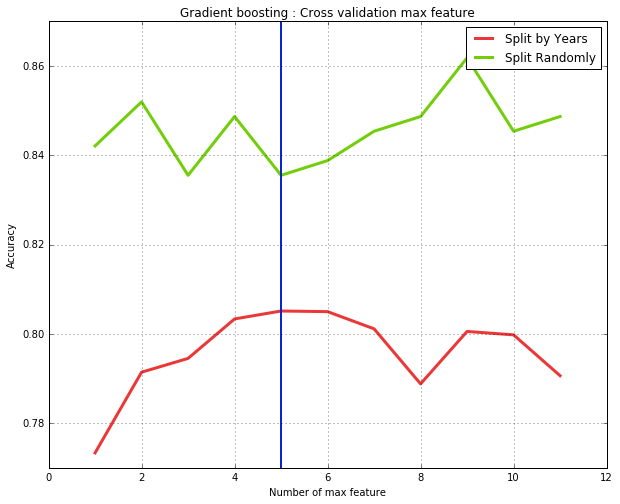

In [52]:
plt.figure(figsize=(10,8))
plt.plot(rangeTab,tabScore, '-', color='#EB3737', linewidth=3, label='Split by Years')
plt.plot(rangeTab,tabScore2, '-', color='#71ce08', linewidth=3, label='Split Randomly')
plt.axvline(x=5,linewidth=2, color='#0825ce')
plt.grid(True)
plt.legend(loc='upper right')
plt.title("Gradient boosting : Cross validation max feature")
plt.ylabel('Accuracy')
plt.xlabel('Number of max feature')
plt.show()


### Best Gradient Boosting

In [58]:
years_prediction=2014
dfTrain=DfSampling[DfSampling['Years']==years_prediction-1]
dfTest=DfSampling[(DfSampling['Years']==years_prediction)]

print " "
print "Entrainement : Nombre d'attaques /nombre de ligne : "+str(len(dfTrain[dfTrain['Count']!=0]))+'/'+str(len(dfTrain))
print "Test : Nombre d'attaques /nombre de ligne : "+str(len(dfTest[dfTest['Count']!=0]))+'/'+str(len(dfTest))

 
Entrainement : Nombre d'attaques /nombre de ligne : 16/132
Test : Nombre d'attaques /nombre de ligne : 16/123


In [59]:
model = GradientBoostingClassifier(random_state=1,n_estimators=200,max_features=5)
model=model.fit(dfTrain[features], dfTrain[target])

predictions=model.predict(dfTest[features])
print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))

print "Pourcentage de précision : "+str(model.score(dfTest[features], dfTest[target]))
cm = confusion_matrix(dfTest[target], predictions)

Nombre d'attaques prévus/Nombre d'attaques réel: 13/16
Pourcentage de précision : 0.878048780488


In [60]:
pd.crosstab(dfTest[target],predictions, colnames=['preds']).apply(lambda r: r/r.sum(), axis=1)

preds,0,1
Attack,,
0,0.943925,0.056075
1,0.562500,0.437500


In [61]:
pd.crosstab(dfTest[target],predictions, colnames=['preds'])

preds,0,1
Attack,,
0,101,6
1,9,7


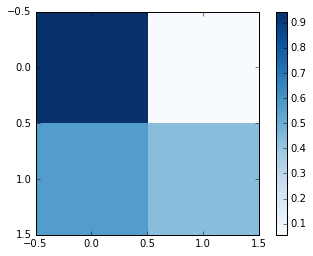

In [62]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Prediction 2015

In [63]:
def getPrediction(dfTrain,dfTest,features,target,nb_esti=250,nb_features=1):
    model = RandomForestClassifier(random_state=1,n_estimators=nb_esti,max_features=nb_features)
    model=model.fit(dfTrain[features], dfTrain[target])
    predictions=model.predict(dfTest[features])
    probabilities=model.predict_proba(dfTest[features])[:, 1]
    return predictions,probabilities

In [64]:
size = len(dfAreaHand["Area"].unique())
ColYears= np.repeat(2015, size)
ColMonth = np.repeat(4, size)
ColFortnight = np.repeat(1, size)
ColType = np.repeat("Tanker", size)
ColActivity = np.repeat(1, size)
ColArea=dfAreaHand["Area"].unique()
       
dic = {'Years': ColYears,'Month': ColMonth,'Fortnight': ColFortnight, 'Area': ColArea,'Type':ColType,'Activity': ColActivity}
dfTest= pd.DataFrame(dic)
dfTest,featureBinary=binaryColumn(dfTest,uniqueArea,uniqueType)


In [65]:
prediction,probabilities=getPrediction(dfAreaHand,dfTest,features,target)
print prediction
print probabilities

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0]
[ 0.02   0.008  0.     0.004  0.008  0.004  0.176  0.004  0.008  0.004
  0.008  0.004  0.008  0.     0.     0.012  0.     0.004  0.008  0.644
  0.632  0.004  0.008  0.008  0.004  0.     0.008  0.668  0.008  0.008
  0.004  0.     0.     0.004  0.004  0.     0.     0.004  0.016  0.004]
